In [1]:
!python -m pip install -U scikit-learn

In [2]:
!python -m pip install tensorflow

In [3]:
!pip install seaborn

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import mediapipe as mp

2025-02-01 21:37:17.579903: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-01 21:37:17.583006: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-01 21:37:17.591139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738426037.604026  146708 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738426037.607870  146708 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-01 21:37:17.622998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [7]:
def draw_styled_landmarks(image, results):

    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [9]:
# Path for exported data, numpy arrays
DATA_PATH = 'data'

# Actions that we try to detect
# actions = np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','S','T','U','V','W','X','Y','Z'])
actions = np.array(['NO_SIGN','A','B','C'])

In [10]:

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 0

In [11]:
label_map = {label:num for num, label in enumerate(actions)}

In [12]:
sequences, labels = [], []
for action in actions: 
    for sequence in range(start_folder,start_folder+no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
    print("completed:"+action+"\n")

completed:NO_SIGN

completed:A

completed:B

completed:C



In [13]:
np.array(sequences).shape

(120, 30, 126)

In [14]:
X = np.array(sequences)

In [15]:
y = to_categorical(labels).astype(int)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,stratify=y)

# Building and Training LSTM Neural Network

## Load the model if already saved

In [17]:
from tensorflow import keras
# model = keras.models.load_model('action.h5')

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [19]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

2025-02-01 21:37:20.430979: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/jaseem/Hackathon/signLanguageModel/venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [22]:
model.fit(X_train, y_train, epochs=250)

Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_accuracy: 0.6346 - loss: 1.0318 
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_accuracy: 0.6111 - loss: 0.9123 
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_accuracy: 0.6568 - loss: 0.7072 
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - categorical_accuracy: 0.6604 - loss: 1.6161 
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_accuracy: 0.6727 - loss: 0.7176 
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_accuracy: 0.5962 - loss: 0.8729 
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_accuracy: 0.6986 - loss: 0.7672
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_accuracy: 0.6586 - loss: 0.7216 
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_accuracy: 0.5182 - loss: 1.9475 
Epoch 10/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_accuracy: 0.5183 - loss: 0.9337
Epoch 11/250
4/4 ━━━━━━━━━━━━━━

# Evaluation

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [24]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


In [25]:
ytrue = np.argmax(y_test, axis=1).tolist()
print(len(ytrue))
yhat = np.argmax(yhat, axis=1).tolist()
print(len(yhat))

12
12


In [26]:
result=np.round(confusion_matrix(ytrue, yhat)/12 ,2)

<Axes: >

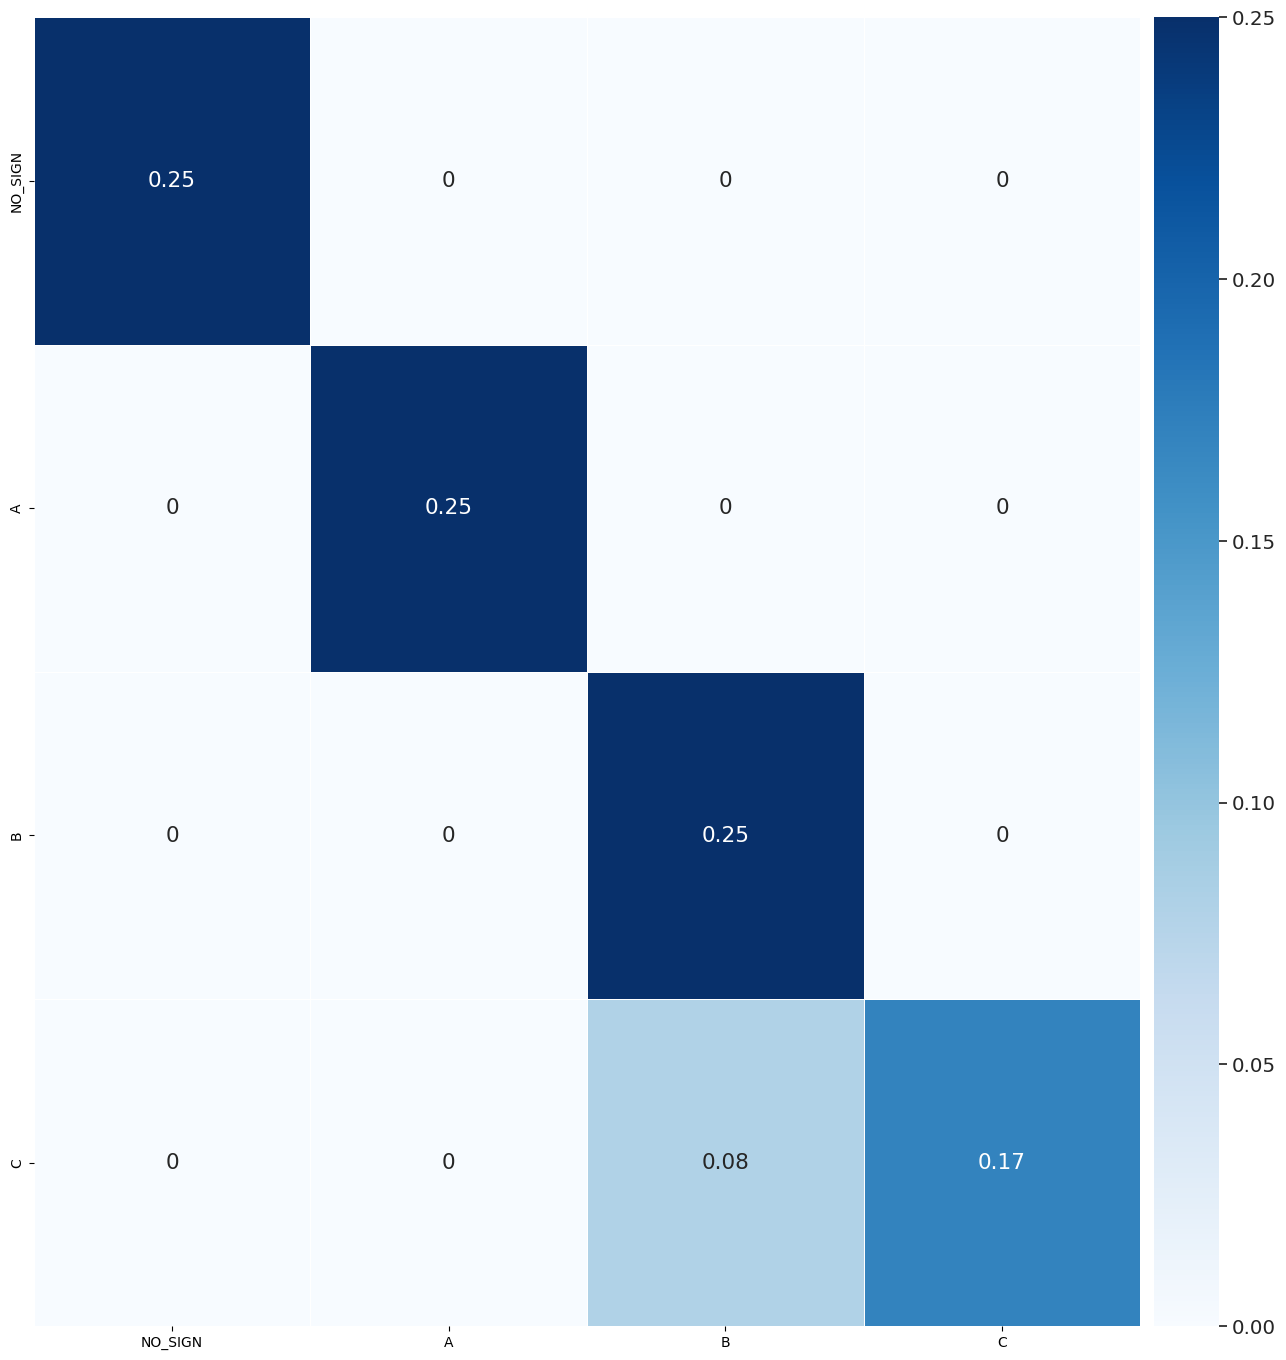

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(17,17))
sns.set(font_scale=1.3) 
sns.heatmap(result, annot=True, linewidth=.5,xticklabels=actions, yticklabels=actions,cmap="Blues",cbar_kws={"orientation": "vertical", "pad": 0.01})

In [28]:
accuracy_score(ytrue, yhat)

0.9166666666666666

In [29]:
model.save('action.h5')

# Test In real Time

In [ ]:
model = keras.models.load_model('action.h5')

# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    #while cap.isOpened():
    i=0;
    while(True):
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            cv2.putText(image, "Detected Sign: "+actions[np.argmax(res)], (320,80), 
                             cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)

        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()


I0000 00:00:1738426119.634335  146708 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1738426119.640636  156513 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.9-0ubuntu0.3), renderer: AMD Radeon Graphics (radeonsi, renoir, LLVM 17.0.6, DRM 3.57, 6.8.0-51-generic)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1738426119.801237  156490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1738426119.892398  156488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1738426119.897909  156491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1738426119.903558  156497 inference_feedback_manager.cc:114] Feedback mana

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

In [ ]:
cap.release()
cv2.destroyAllWindows()